# Simple Enhanced Analytics

Improved visualizations using only standard libraries.

In [4]:
# Simple setup without pandas
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from collections import defaultdict, Counter

# Setup path
ROOT = Path.cwd()
if (ROOT / "notebooks").exists() and not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

from dotenv import load_dotenv
load_dotenv()

from src.common.db import get_logs_collection

# Enhanced plotting style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Simple analytics setup complete")

✅ Simple analytics setup complete


In [5]:
# Load data with enhanced analysis
WINDOW_MIN = 60

def load_and_analyze_data(minutes=WINDOW_MIN):
    coll = get_logs_collection()
    since = datetime.now(timezone.utc) - timedelta(minutes=minutes)
    
    docs = list(coll.find({"ts": {"$gte": since}}).sort("ts", 1))
    
    if not docs:
        print(f"⚠️ No data found in last {minutes} minutes")
        return None
    
    # Group by cell
    by_cell = defaultdict(list)
    for doc in docs:
        by_cell[doc['cell_id']].append(doc)
    
    print(f"📊 Loaded {len(docs)} records from {len(by_cell)} cells")
    return docs, dict(by_cell)

result = load_and_analyze_data()
if result:
    docs, by_cell = result
else:
    docs, by_cell = [], {}

📊 Loaded 336 records from 12 cells


## 📈 Enhanced System Dashboard

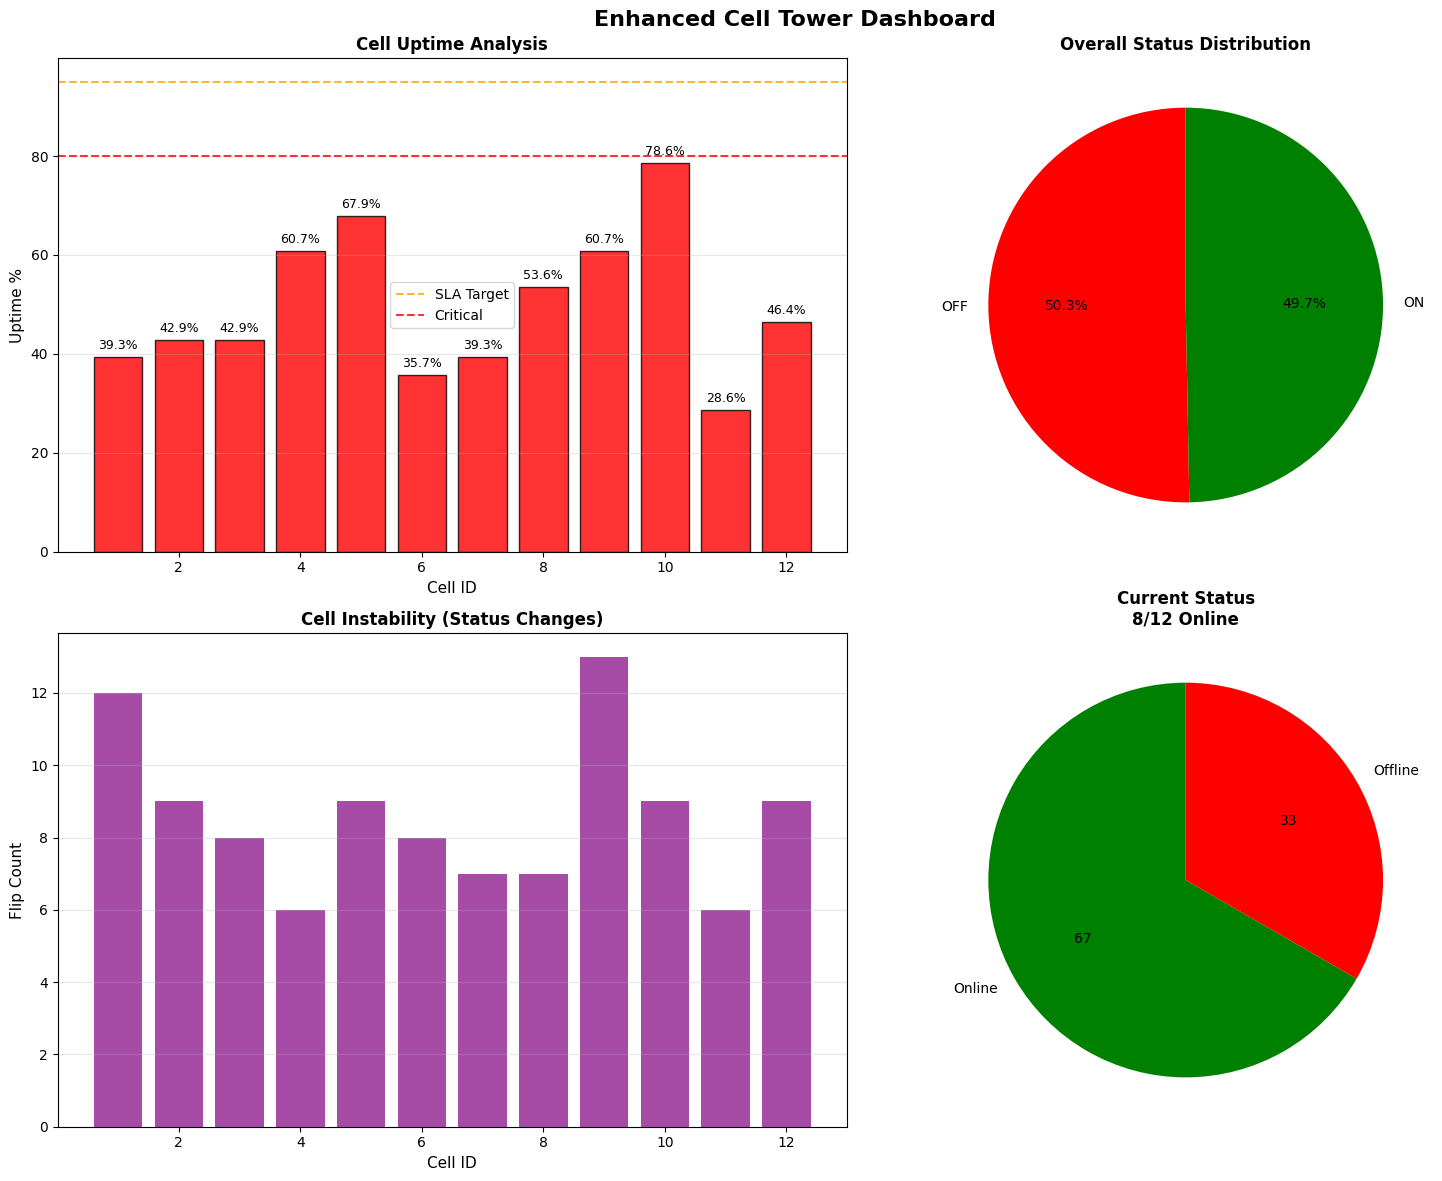


🔍 ENHANCED INSIGHTS:
• System average uptime: 49.7%
• SLA compliant cells: 0/12 (0.0%)
• Critical cells (<80%): 12
• Most unstable cell: 9 (13 flips)
• Current system availability: 66.7%

🚨 CRITICAL CELLS REQUIRING ATTENTION: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

⚠️ SYSTEM BELOW SLA TARGET (95%)


In [6]:
if docs:
    # Create enhanced dashboard
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Enhanced Cell Tower Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Cell uptime with color coding
    uptimes = {}
    for cell_id, logs in by_cell.items():
        on_count = sum(1 for log in logs if log['status'] == 'ON')
        total = len(logs)
        uptimes[cell_id] = (on_count / total * 100) if total > 0 else 0
    
    cell_ids = sorted(uptimes.keys())
    uptime_values = [uptimes[cid] for cid in cell_ids]
    
    # Color code: red < 80%, orange < 95%, green >= 95%
    colors = ['red' if u < 80 else 'orange' if u < 95 else 'green' for u in uptime_values]
    
    bars = axes[0,0].bar(cell_ids, uptime_values, color=colors, alpha=0.8, edgecolor='black')
    axes[0,0].set_title('Cell Uptime Analysis', fontweight='bold', fontsize=12)
    axes[0,0].set_ylabel('Uptime %', fontsize=11)
    axes[0,0].set_xlabel('Cell ID', fontsize=11)
    axes[0,0].axhline(y=95, color='orange', linestyle='--', alpha=0.8, label='SLA Target')
    axes[0,0].axhline(y=80, color='red', linestyle='--', alpha=0.8, label='Critical')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, uptime in zip(bars, uptime_values):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                      f'{uptime:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Status distribution
    status_counts = Counter(doc['status'] for doc in docs)
    labels = list(status_counts.keys())
    values = list(status_counts.values())
    colors_pie = ['green' if label == 'ON' else 'red' for label in labels]
    
    axes[0,1].pie(values, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Overall Status Distribution', fontweight='bold', fontsize=12)
    
    # 3. Instability analysis (flip count)
    flip_counts = {}
    for cell_id, logs in by_cell.items():
        flips = 0
        prev_status = None
        for log in logs:
            if prev_status and log['status'] != prev_status:
                flips += 1
            prev_status = log['status']
        flip_counts[cell_id] = flips
    
    flip_ids = sorted(flip_counts.keys())
    flip_values = [flip_counts[cid] for cid in flip_ids]
    
    axes[1,0].bar(flip_ids, flip_values, color='purple', alpha=0.7)
    axes[1,0].set_title('Cell Instability (Status Changes)', fontweight='bold', fontsize=12)
    axes[1,0].set_ylabel('Flip Count', fontsize=11)
    axes[1,0].set_xlabel('Cell ID', fontsize=11)
    axes[1,0].grid(True, alpha=0.3, axis='y')
    
    # 4. Current system status
    current_status = {}
    for cell_id, logs in by_cell.items():
        if logs:
            current_status[cell_id] = logs[-1]['status']  # Last status
    
    online_count = sum(1 for status in current_status.values() if status == 'ON')
    offline_count = len(current_status) - online_count
    
    axes[1,1].pie([online_count, offline_count], labels=['Online', 'Offline'], 
                  colors=['green', 'red'], autopct='%1.0f', startangle=90)
    axes[1,1].set_title(f'Current Status\n{online_count}/{len(current_status)} Online', 
                        fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print enhanced insights
    avg_uptime = sum(uptime_values) / len(uptime_values) if uptime_values else 0
    sla_compliant = sum(1 for u in uptime_values if u >= 95)
    critical_cells = sum(1 for u in uptime_values if u < 80)
    most_unstable = max(flip_counts.items(), key=lambda x: x[1]) if flip_counts else (None, 0)
    
    print("\n🔍 ENHANCED INSIGHTS:")
    print(f"• System average uptime: {avg_uptime:.1f}%")
    print(f"• SLA compliant cells: {sla_compliant}/{len(uptime_values)} ({sla_compliant/len(uptime_values)*100:.1f}%)")
    print(f"• Critical cells (<80%): {critical_cells}")
    print(f"• Most unstable cell: {most_unstable[0]} ({most_unstable[1]} flips)")
    print(f"• Current system availability: {online_count/len(current_status)*100:.1f}%")
    
    if critical_cells > 0:
        critical_list = [cid for cid, u in zip(cell_ids, uptime_values) if u < 80]
        print(f"\n🚨 CRITICAL CELLS REQUIRING ATTENTION: {critical_list}")
    
    if avg_uptime < 95:
        print(f"\n⚠️ SYSTEM BELOW SLA TARGET (95%)")
else:
    print("❌ No data available for enhanced analysis")